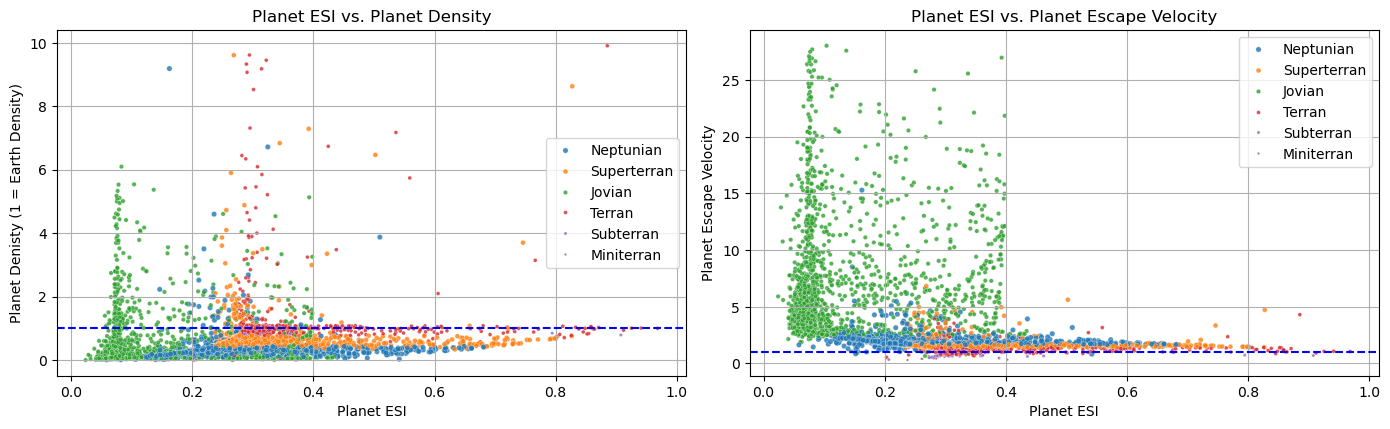

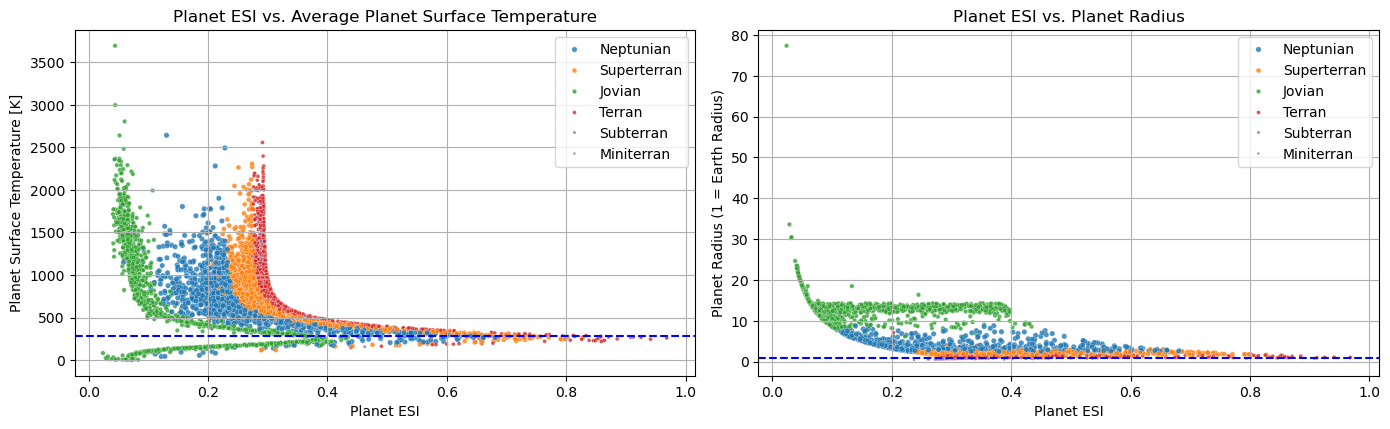

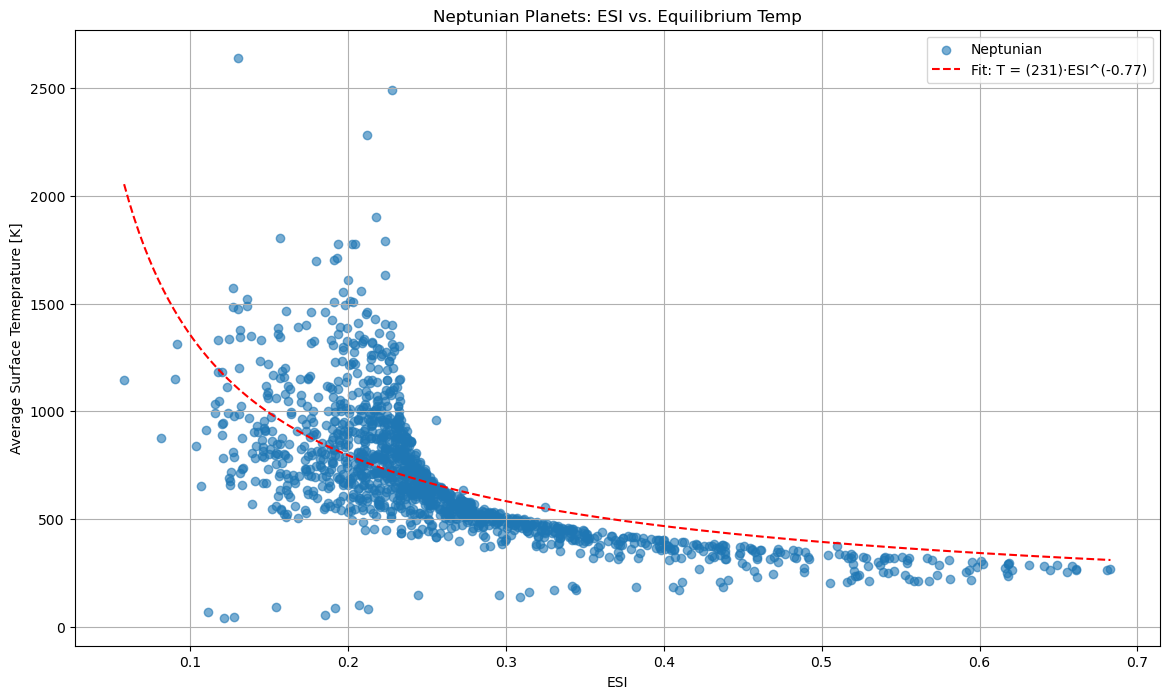

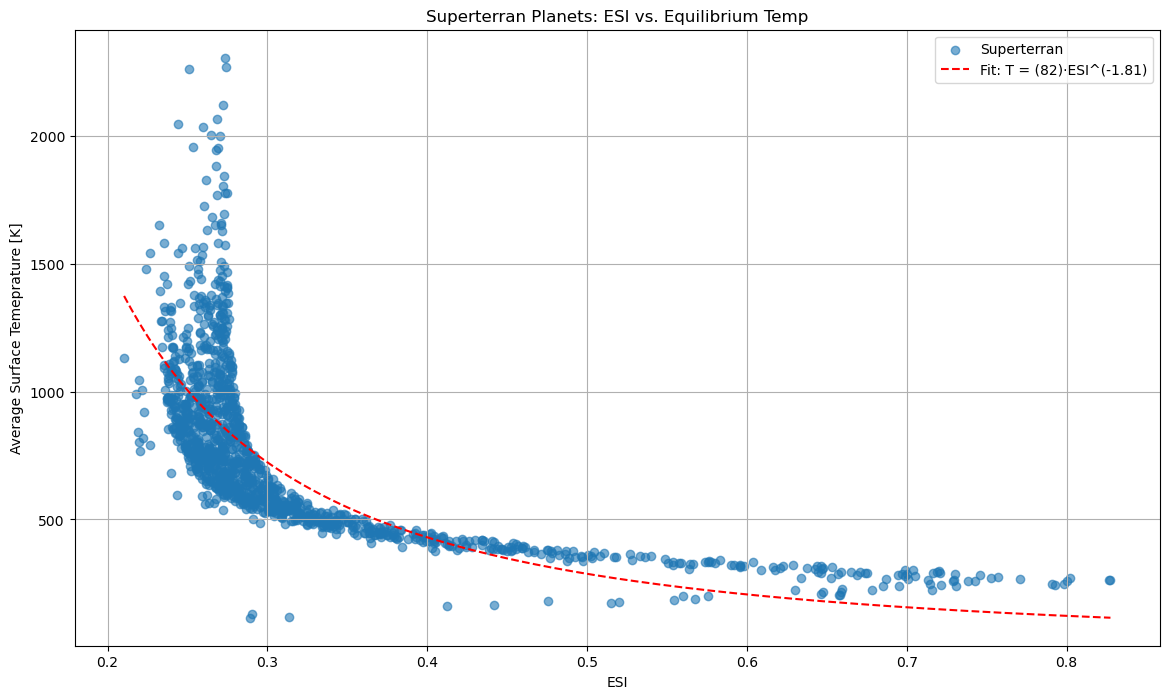

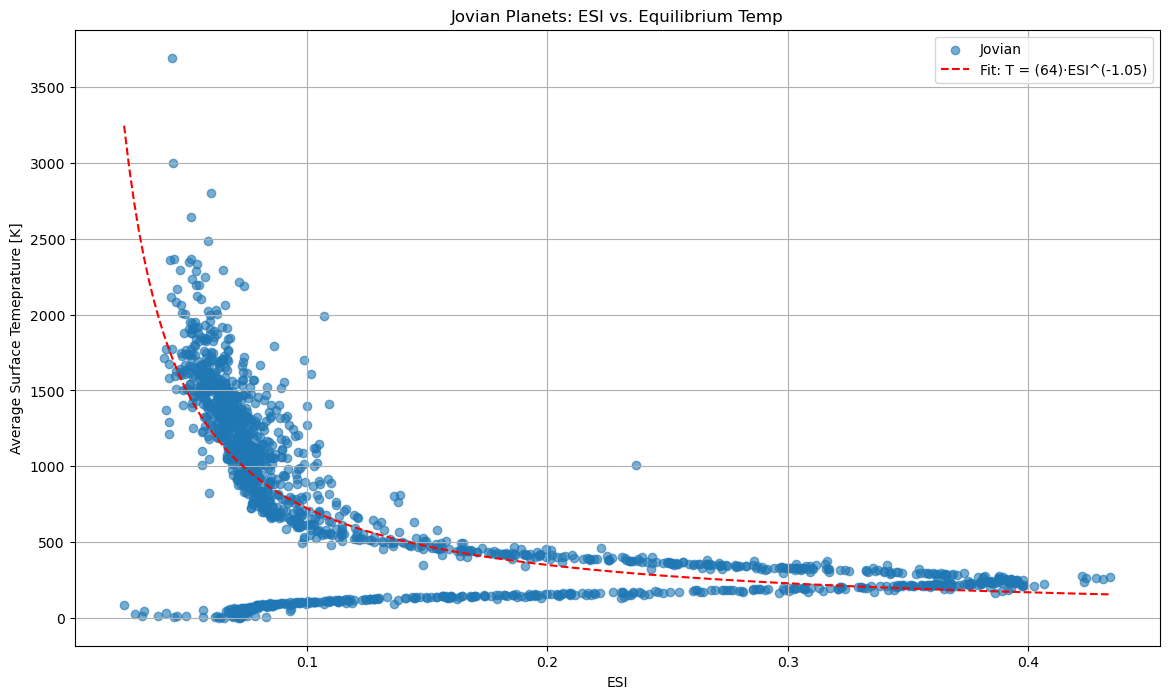

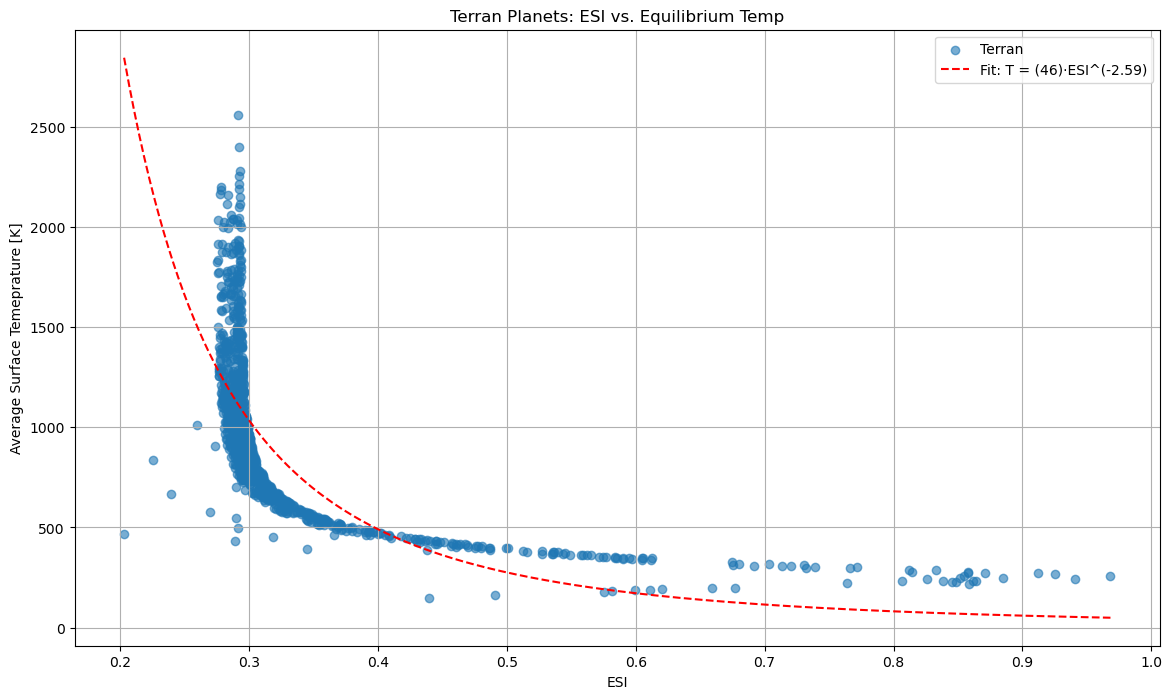

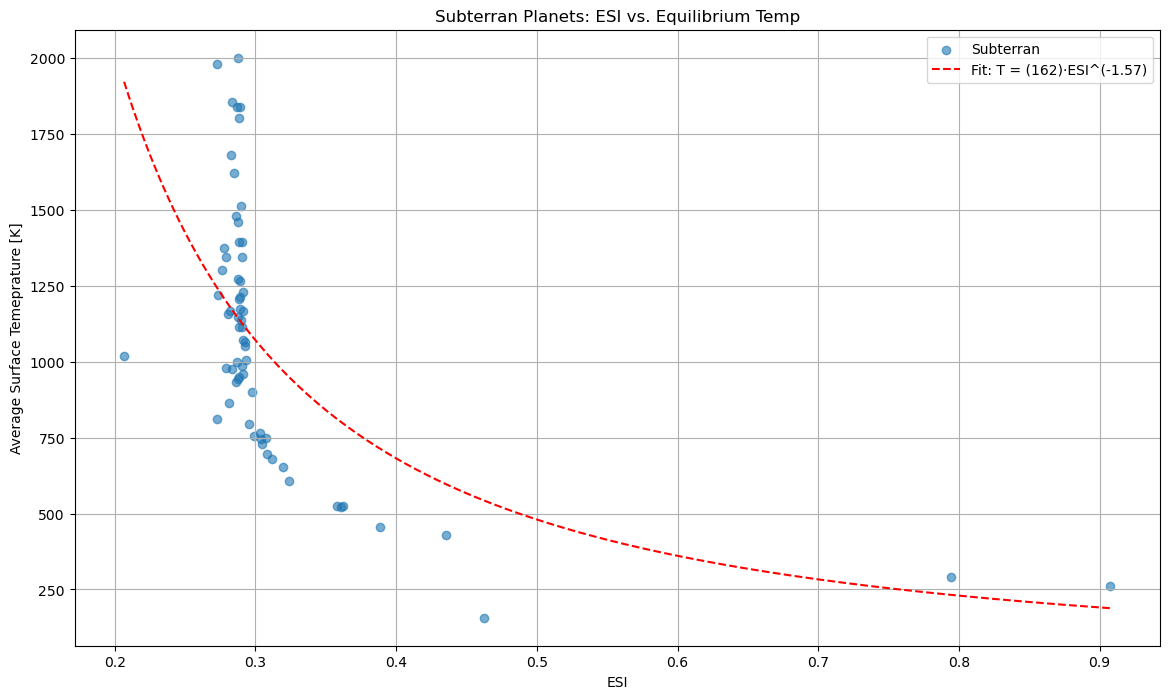

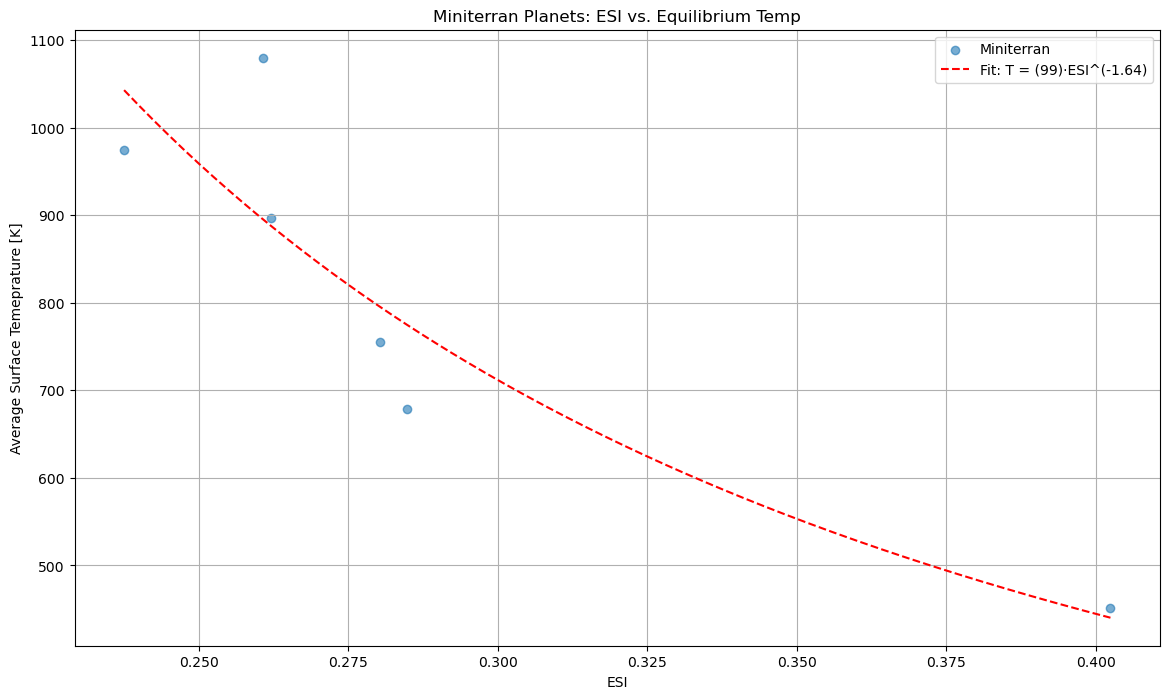

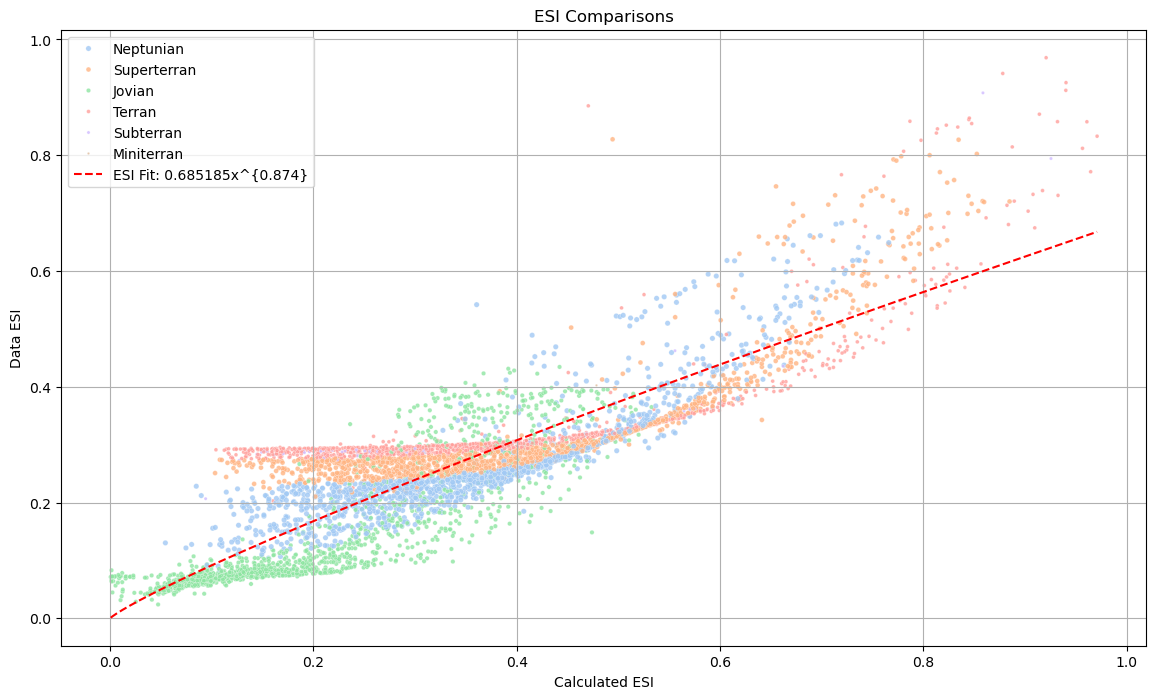

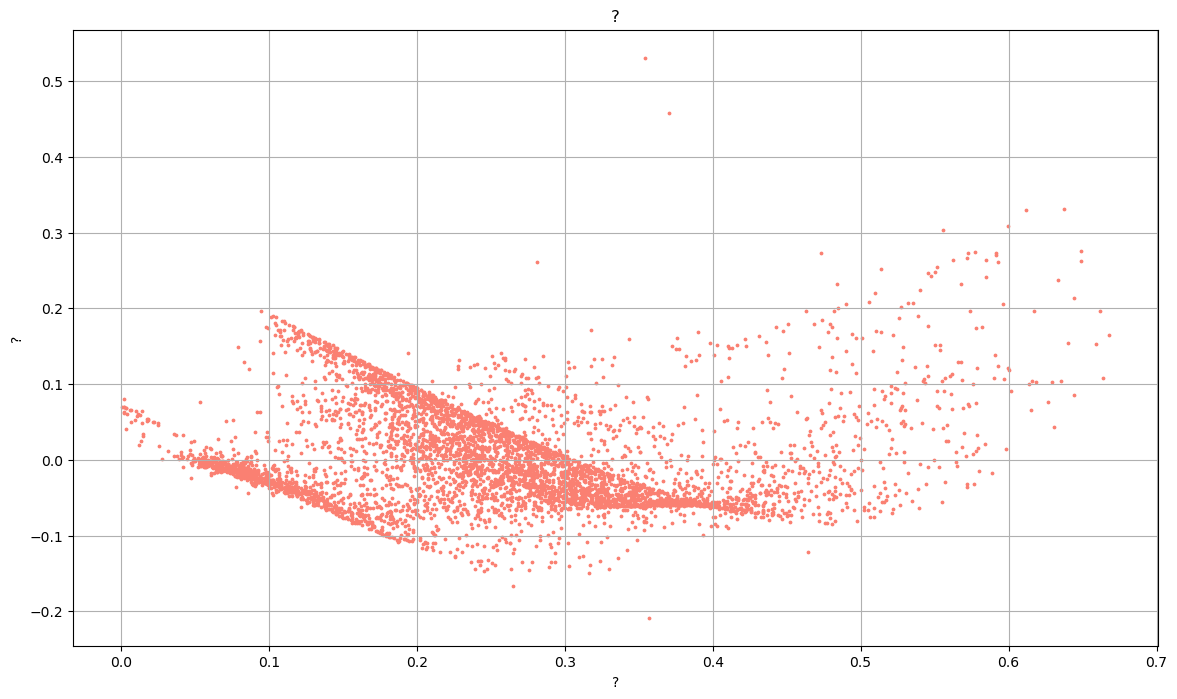

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
import scipy.optimize as fit
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

df = pd.read_csv('hwc.csv')

#drop nan values and filter down for smoother looking plot
df = df.dropna(subset=['P_ESI','P_RADIUS','P_DENSITY', 'P_ESCAPE', 'P_TEMP_EQUIL', 'P_TYPE'])
df = df[df['P_DENSITY'] < 10]
df = df[df['P_ESCAPE'] < 30]
df = df[df['P_TEMP_EQUIL'] < 4000]

#sorting data
df_sorted = df.sort_values(by='P_ESI')
x_data = df_sorted['P_ESI']
y_data = df_sorted['P_DENSITY']
y2_data = df_sorted['P_ESCAPE']
y3_data = df_sorted['P_TEMP_EQUIL']
y4_data = df_sorted['P_RADIUS']

#density vs esi plotted by planet type (hue)
plt.figure(figsize=(14, 8))

plt.subplot(2,2,1)
sns.scatterplot(
    data=df,
    x = x_data,
    y = y_data,   # Keep in Earth radii
    hue='P_TYPE',
    size='P_TYPE',
    sizes= (3, 15),
    color = "magma",
    alpha=0.8
)
plt.xlabel("Planet ESI")
plt.ylabel("Planet Denisty (1 = Earth Density)")
plt.axhline(y=1, color='b', linestyle='--') #earth density
plt.title("Planet ESI vs. Planet Density")
plt.legend()
plt.tight_layout()
plt.grid(True)

#escape velocity vs esi plotted by planet type (hue)
plt.subplot(2,2,2)
sns.scatterplot(
    data=df,
    x = x_data,
    y = y2_data,   # Keep in Earth radii
    hue='P_TYPE',
    size='P_TYPE',
    sizes= (3, 15),
    color = "magma",
    alpha=0.8
)
plt.xlabel("Planet ESI")
plt.ylabel("Planet Escape Velocity")
plt.axhline(y=1, color='b', linestyle='--') #earth escape velocity
plt.title("Planet ESI vs. Planet Escape Velocity")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

#surf temp vs esi plotted by planet type (hue)
plt.figure(figsize=(14, 8))

plt.subplot(2,2,1)
sns.scatterplot(
    data=df,
    x = x_data,
    y = y3_data,   # Keep in Earth radii
    hue='P_TYPE',
    size='P_TYPE',
    sizes= (3, 15),
    color = "magma",
    alpha=0.8
)
plt.xlabel("Planet ESI")
plt.ylabel("Planet Surface Temperature [K]")
plt.axhline(y=288, color='b', linestyle='--') #earth surf temp
plt.title("Planet ESI vs. Average Planet Surface Temperature")
plt.legend()
plt.tight_layout()
plt.grid(True)

#radius vs esi plotted by planet type (hue)
plt.subplot(2,2,2)
sns.scatterplot(
    data=df,
    x = x_data,
    y = y4_data,   # Keep in Earth radii
    hue='P_TYPE',
    size='P_TYPE',
    sizes= (3, 15),
    color = "magma",
    alpha=0.8
)
plt.xlabel("Planet ESI")
plt.ylabel("Planet Radius (1 = Earth Radius)")
plt.axhline(y=1, color='b', linestyle='--')
plt.title("Planet ESI vs. Planet Radius")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################

#define model function for temp and ESI relationship 
def ESI_temp_func(x, a, b, ):
    return a * x**b 

#get the unique planet types in our table
planet_types = df['P_TYPE'].unique()

#loop over each type
for ptype in planet_types:
    #select only this type and drop any rows where ESI or Temp is missing
    sub = df[df['P_TYPE'] == ptype].dropna(subset=['P_ESI','P_TEMP_EQUIL'])
    
    #extract our x and y arrays
    x_data = sub['P_ESI'].values
    y_data = sub['P_TEMP_EQUIL'].values

    #fit the model to the data
    params , covar = fit.curve_fit(ESI_temp_func, x_data, y_data, p0=[3000, -1.0])
    a, b = params

    #fit curve
    xs = np.linspace(x_data.min(), x_data.max(), 200)
    ys = ESI_temp_func(xs, a, b)

    #plot for each unique planet type in current loop
    plt.figure(figsize = (14, 8)) 
    plt.scatter(x_data, y_data, label=f'{ptype}', alpha=0.6)
    plt.plot(xs, ys, 'r--', label=f'Fit: T = ({a:.0f})·ESI^({b:.2f})')
    plt.title(f'{ptype} Planets: ESI vs. Equilibrium Temp')
    plt.xlabel('ESI')
    plt.ylabel('Average Surface Temeprature [K]')
    plt.legend()
    plt.grid(True)
    plt.show()

#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################
#######################################################################################################################################

'Now I will incorporate utilize a theoretical model for the ESI to plot against the ESI values in the data. This model function was taken from wiki.'\

#earth values for params
earth = {
    'P_RADIUS': 1.0,
    'P_DENSITY': 1.0,
    'P_ESCAPE': 1.0,
    'P_TEMP_EQUIL': 288
}

#weights of params for similarity function
weights = {
    'P_RADIUS': 0.57,
    'P_DENSITY': 1.07,
    'P_ESCAPE': 0.70,
    'P_TEMP_EQUIL': 5.58
}

#similarity function
def compute_ESI(row):
    n = len(weights)
    product = 1
    for param in weights:
        x = row[param]
        x0 = earth[param]
        w = weights[param]
        esi_component = 1 - abs((x - x0) / (x + x0))
        product *= esi_component ** (w / n)
    return product

#create column using function above
df['ESI_CALC'] = df.apply(compute_ESI, axis=1)

#assign variables to columns
x_ESI = df['ESI_CALC']
y_ESI = df['P_ESI']

#fit for plotting x_ESI and y_ESI
def ESI_fit(x,a,b):
    return a * x**b

params, covariance = fit.curve_fit(
    ESI_fit, 
    x_ESI, 
    y_ESI,  
    p0 = [1, 2]
)

a, b = params

y_model = ESI_fit(x_ESI, *params)
residuals = y_ESI - y_model

x_fit = np.linspace(x_ESI.min(), x_ESI.max(), 500)
y_fit = ESI_fit(x_fit, *params)

# esi versus calc esi 
plt.figure(figsize = (14,8))
sns.scatterplot(
    data=df,
    x = x_ESI,
    y = y_ESI,   # Keep in Earth radii
    hue='P_TYPE',
    size='P_TYPE',
    palette = 'pastel',
    sizes= (3, 15),
    alpha=0.8
)
#fit curve
plt.plot(
    x_fit, 
    y_fit, 
    color='red', 
    linestyle='--', 
    label=f'ESI Fit: {a:.6f}x^{{{b:.3f}}}',
    zorder = 2
)
plt.xlabel('Calculated ESI')
plt.ylabel('Data ESI')
plt.title('ESI Comparisons')
plt.legend()
plt.grid(True)
plt.show

#residuals
plt.figure(figsize = (14,8))
plt.scatter(
    y_model, 
    residuals,
    s = 3,
    color = "salmon"
)
plt.xlabel("?")
plt.ylabel("?")
plt.title("?")
plt.grid(True)
plt.show()

